In [1]:
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller

In [2]:
df = quandl.get("USTREASURY/YIELD")
df = df.drop(["1 MO", "2 MO"], axis=1)
sample_1 = df.loc["2012-03-01": "2015-07-30"]
sample_1.head(5)

,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,
2012-03-01,0.08,0.13,0.18,0.30,0.43,0.89,1.44,2.03,2.80,3.15
2012-03-02,0.07,0.12,0.17,0.28,0.41,0.84,1.38,1.99,2.77,3.11
2012-03-05,0.08,0.14,0.17,0.31,0.43,0.87,1.40,2.00,2.78,3.13
2012-03-06,0.08,0.13,0.17,0.30,0.40,0.83,1.35,1.96,2.73,3.08
2012-03-07,0.08,0.14,0.18,0.30,0.42,0.85,1.37,1.98,2.76,3.12


In [3]:
sample_1.isna().sum(axis=0)

3 MO     0
6 MO     0
1 YR     0
2 YR     0
3 YR     0
5 YR     0
7 YR     0
10 YR    0
20 YR    0
30 YR    0
dtype: int64

In [4]:
t = df.columns.tolist()
l = [len(x) for x in t]
term = [float(x[0:(ll-2)])*(x[-2:]=='YR')+float(x[0:(ll-2)])/12*(x[-2:]=='MO') for x,ll in zip(t,l)]
print(term)

[0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0]


### PCA  
#### For PCA we should use differenced stationary data 

In [5]:
# using scikit-learn
sample_1_diff = sample_1.diff(1).dropna()
pca = PCA(n_components=3).fit(sample_1_diff)
loading = pca.components_  # Unit Orthogonal Basis
var_ratio = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))
print ('% variance explained:')
print ('sklearn:', var_ratio)

# using mathematical eigenvalue decomposition
c = sample_1_diff.cov()
val, vec = np.linalg.eig(c)
tr = sum(val)
var_ratio_custom = np.cumsum(np.round(val/tr, decimals=4))[:3]
print ('manually:',var_ratio_custom)

% variance explained:
sklearn: [0.8757 0.9515 0.9656]
manually: [0.8757 0.9515 0.9656]


From the above result we can see that the eigenvalue decomposition is the same as using PCA by scikit learn

In [6]:
np.sum(loading[0] ** 2)

1.0

This is a unit base vector

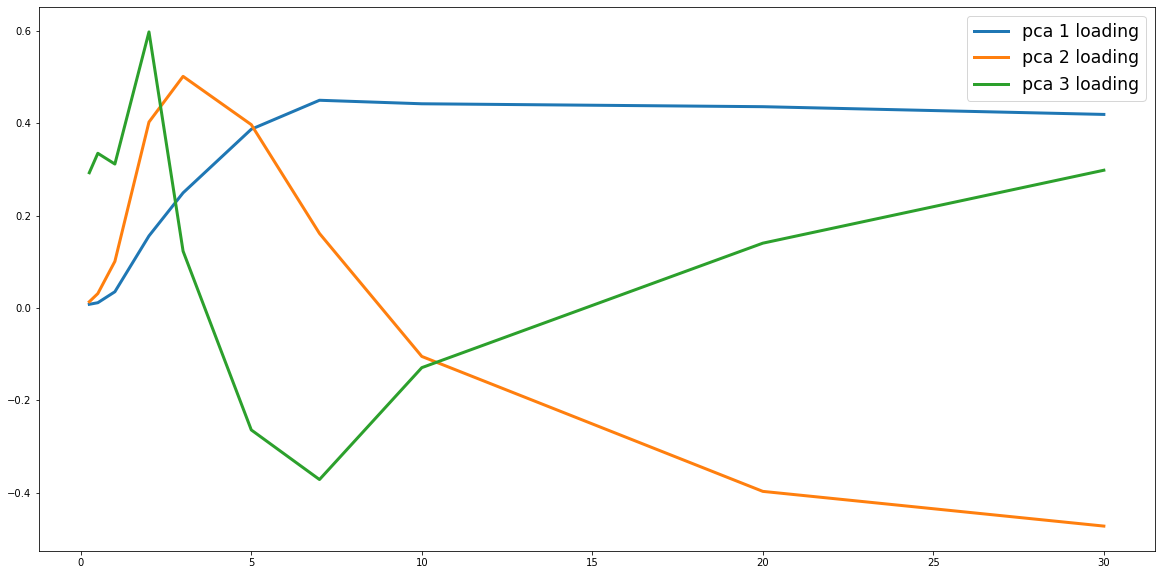

In [7]:
plt.figure(figsize=(20, 10))
for i in range(len(loading)):
    plt.plot(term, loading[i], label=f'pca {i + 1} loading', linewidth=3)
    plt.legend(loc='best', fontsize='xx-large') 

the above loading is calculated by sample data (sample 1) from 2012-03-01 to 2015-07-30, which can be treated as sensitivity of PC factors on original cmt yield data

In [8]:
def calc_model_cmt(frame, eigen_vector, pc_num=3):
    """
    
    :param frame: pd.DataFrame; out of sample data, should be after 2015-07-30
    :param eigen_vector: np.array; eigen_vector calculated through sample data, should be before 2015-07-30
    :param pc_num: int; number of pc used to calculate model cmt
    :return : pd.DataFrame; model cmt data frame
    """
    out_of_sample_pc = np.dot(frame.values, vec[:, :pc_num])
    model_cmt = np.dot(out_of_sample_pc, vec[:, :pc_num].T)
    model_cmt = pd.DataFrame(model_cmt, columns=frame.columns, index=frame.index)
    return model_cmt

This function is used to calculate model cmt yield of based on eigen vectors calculated by sample data. Model cmt yield can be calculated by dot product of out of sample PC factors and transpose or invert of eigen vectors.

In [9]:
def plotme(dts, frame, model_frame, pc_num_key, term=term):
    """
    
    :param dts: list; list of dates as a string
    :param frame: pd.DataFrame; a dataframe in which these strings exists
    :param term: list; the terms/maturities that your data contains
    """
    f = plt.figure(figsize=(20,10))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    x = term    
    crvs = [frame.loc[dt] for dt in dts]
    crvs_model = [model_frame.loc[dt] for dt in dts]
    plots = [plt.plot(x, crv.values, label=dt, linewidth=3) for crv, dt in zip(crvs, dts)]
    plots = [plt.plot(x, crv.values, label=dt + pc_num_key, linewidth=3) for crv, dt in zip(crvs_model, dts)]
    plt.legend(loc='lower right',fontsize='xx-large')    
    plt.show()
    plt.clf()

In [10]:
out_of_sample_1 = df.loc["2015-07-31":]
model_cmt_pc_dict = dict()
for i in range(1, 4):
    model_cmt_pc_dict[f"model_use_first_{i}_pc"] = calc_model_cmt(out_of_sample_1, vec, pc_num=i)

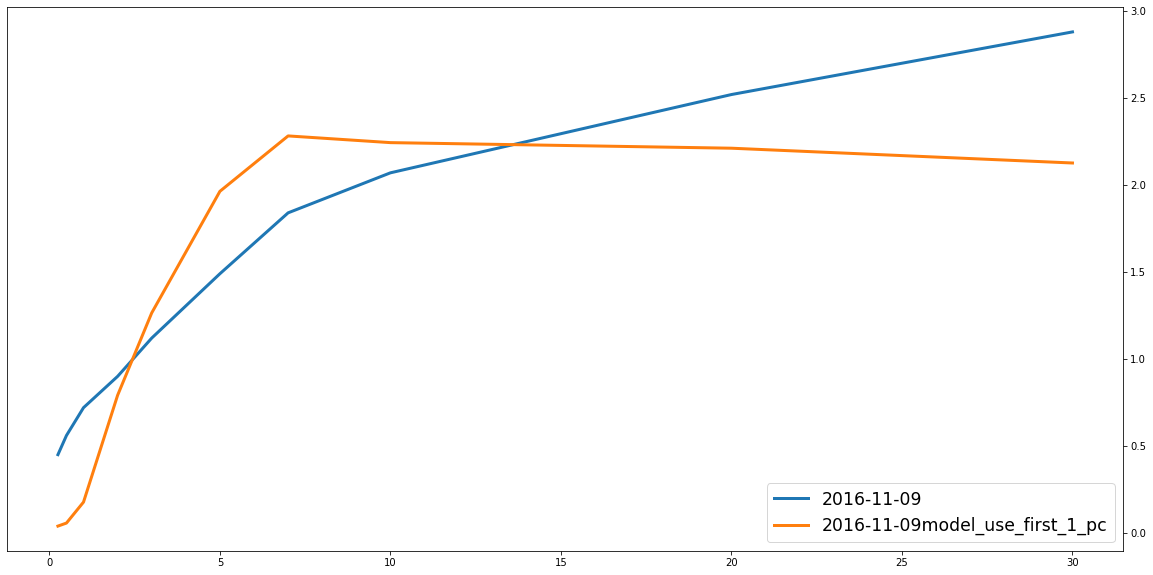

<Figure size 432x288 with 0 Axes>

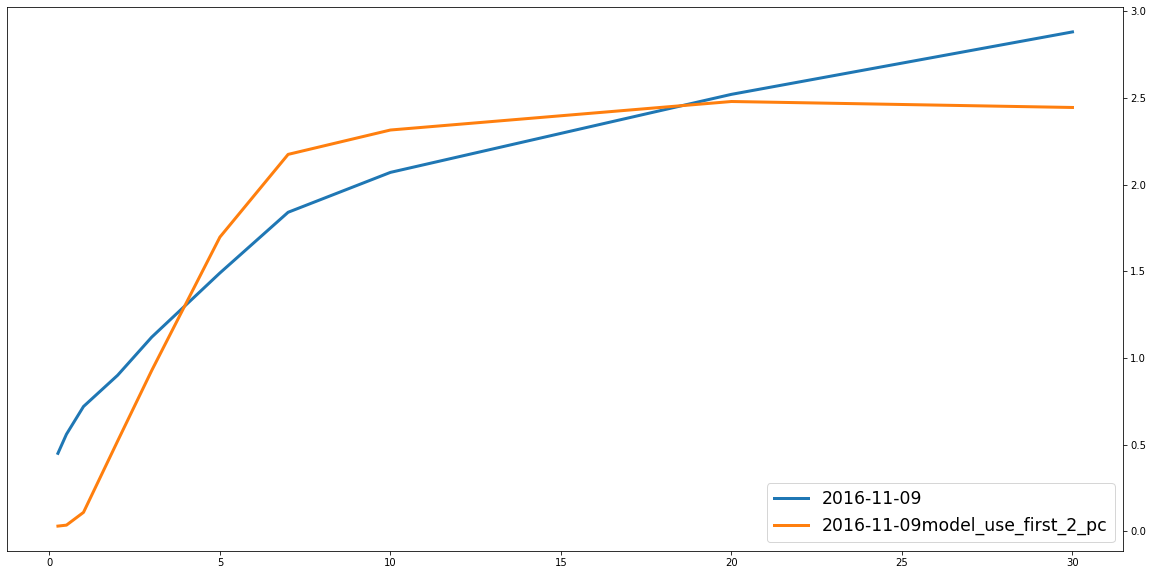

<Figure size 432x288 with 0 Axes>

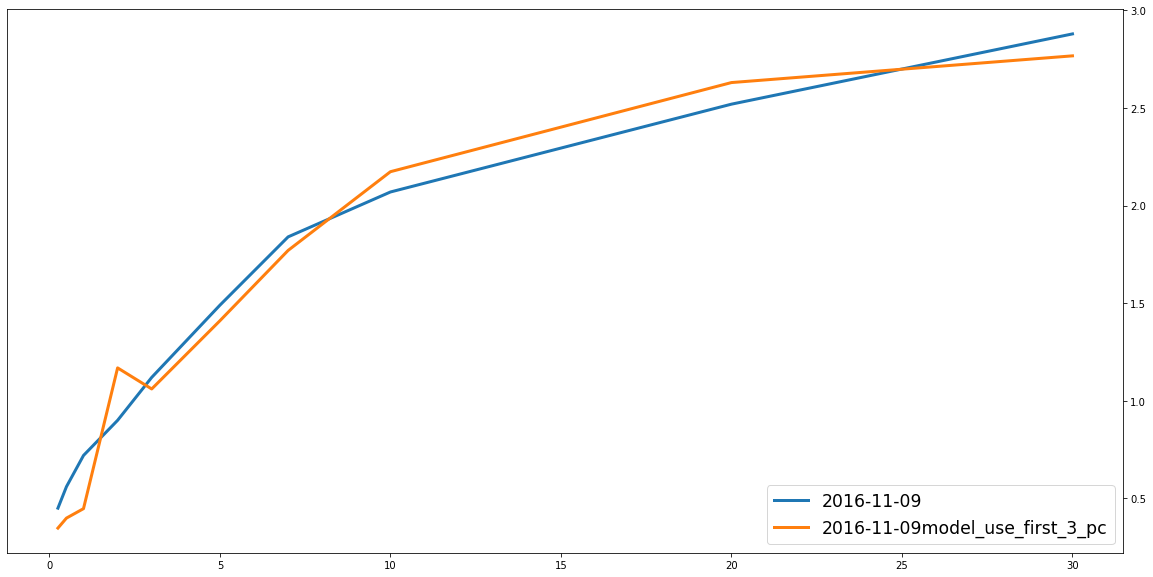

<Figure size 432x288 with 0 Axes>

In [11]:
dts = ['2016-11-09']
for key in model_cmt_pc_dict.keys():
    plotme(dts, pd.DataFrame(df.loc['2016-11-09':'2016-11-09']), model_cmt_pc_dict[key], key, term)

From the above three plots we can see that by using more PCs, the model cmt yield would be more and more precise and much closer to the real cmt yield.

In [12]:
w_3y_pc1, w_5y_pc1, w_7y_pc1 = vec[4, 0], vec[5, 0], vec[6, 0]
w_3y_pc2, w_5y_pc2, w_7y_pc2 = vec[4, 1], vec[5, 1], vec[6, 1]

The above values are sensitivities of cmt yield to PC1 and PC2 which equal to factor loadings.  
for example: w_3y_pc1 represents the 3 YR's sensitvity to PC1 which can be extract from eigen value matrix

In [13]:
A = np.array([[w_3y_pc1, w_7y_pc1], [w_3y_pc2, w_7y_pc2]])
b = np.array([w_5y_pc1, w_5y_pc2])
r = np.linalg.solve(A, b)
print(r)

[0.62642558 0.51333299]


This weight can be calculated through a system of linear equations, in order to make WFLY insensitive to PC1 and PC2

In [14]:
WFLY1 = r[0] * sample_1["3 YR"] - sample_1["5 YR"] + r[1] * sample_1["7 YR"]
WFLY1

Date
2012-03-01    0.118562
2012-03-02    0.125234
2012-03-05    0.118029
2012-03-06    0.113570
2012-03-07    0.116365
                ...   
2015-07-24    0.048415
2015-07-27    0.052558
2015-07-28    0.056751
2015-07-29    0.074679
2015-07-30    0.087208
Length: 856, dtype: float64

### CCA
#### For CCA we should use level data

In [15]:
def CCA_Chou_Ng(data_set):
    
    """ data_set is pandas dataframe """
    
    # define df_lag as the 1-period lag of data_set
    df_lag = data_set.shift(1).dropna()
    
    # drop the 0-index of data_set to make sure df and df_lag are aligned
    df = data_set.drop(data_set.index[0]).dropna()
    n = len(data_set.columns)
    
    # X(t) ~ M_1 + X(t-1)
    
    # input variables
    X = df_lag.values
    
    # ensures there is an intercept
    X_I = sm.add_constant(X)
    
    # regression target
    Y = df.values
    
    # fit regression
    l1 = sm.OLS(Y,X_I).fit()
    
    # get the coefficients/betas without the intercept
    B=l1.params[1:(n+1)]
    # print(B)
    
    # X(t-1) ~ M_2 + X(t)
    
    # regression, reversing the dependent and the independent
    Y_I = sm.add_constant(Y)
    l2 = sm.OLS(X,Y_I).fit()
    
    # get the coefficients/betas without the intercept
    A=l2.params[1:(n+1)]
    # print(A)
    
    # take the dot product of the two coefficient matrices
    C = np.dot(A,B)
    print(C)
    eig_val, eig_vec = np.linalg.eig(C)
    
    return eig_val, eig_vec, C

In [16]:
legs = ['3 YR', '7 YR']
belly = '5 YR'
flylist = [legs[0], belly, legs[1]]
fly = sample_1[flylist]
df1 = fly
n = len(df1.columns)
val_cca, vec_cca, C_cca = CCA_Chou_Ng(df1)

[[ 0.74501506 -0.18958809 -0.30944912]
 [ 0.38604929  1.28693706  0.48665071]
 [-0.22587177 -0.17304438  0.70597506]]


In [17]:
vec_cca = pd.DataFrame(vec_cca)
vec_cca = vec_cca.rename(columns=lambda x: n-x-1, inplace=False)
w = vec_cca[2].values
w_cca_cn = [-w[0]/w[1],-w[2]/w[1]]
w_cca_cn

[0.6311987858075564, 0.5862682655326176]

we can see that w1 and w2 are almost the same under both risk neutral method and CCA

In [18]:
WFLY2 = w_cca_cn[0] * sample_1["3 YR"] - sample_1["5 YR"] + w_cca_cn[1] * sample_1["7 YR"]
WFLY2

Date
2012-03-01    0.225642
2012-03-02    0.227842
2012-03-05    0.222191
2012-03-06    0.213942
2012-03-07    0.218291
                ...   
2015-07-24    0.200709
2015-07-27    0.200285
2015-07-28    0.206809
2015-07-29    0.227021
2015-07-30    0.239645
Length: 856, dtype: float64

In [19]:
def get_halflife(s):
    """
    Calculate halflife of a time series
    :param s: pd.Series; a given time series
    :return halflife: int; halflife of a given time series
    """
    s_lag = s.shift(1)
    s_lag.iloc[0] = s_lag.iloc[1]
 
    s_ret = s - s_lag
    s_ret.iloc[0] = s_ret.iloc[1]
 
    s_lag2 = sm.add_constant(s_lag)
 
    model = sm.OLS(s_ret,s_lag2)
    res = model.fit()
 
    halflife = round(-np.log(2) / list(res.params)[1], 4)
    return halflife


def adf_test(timeseries):
    """
    adfuller test
    :param timeseries: pd.Series;
    :return :
    """
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    

def acf_pacf_plot(ts_log_diff):
    """
    ACF and PACF plot
    :param ts_log_diff: pd.Series;
    """
    sm.graphics.tsa.plot_acf(ts_log_diff,lags=40)  # ARIMA,q
    sm.graphics.tsa.plot_pacf(ts_log_diff,lags=40)  # ARIMA,p

Test Statistic                  -2.106289
p-value                          0.241993
#Lags Used                       4.000000
Number of Observations Used    851.000000
Critical Value (1%)             -3.438058
Critical Value (5%)             -2.864942
Critical Value (10%)            -2.568582
dtype: float64


D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


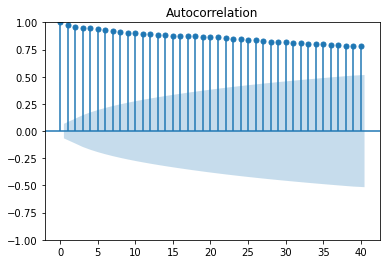

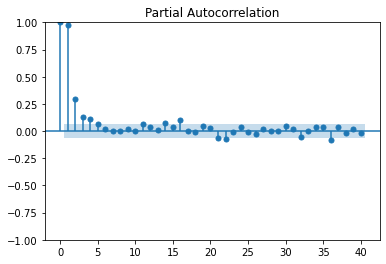

In [20]:
adf_test(WFLY1)
acf_pacf_plot(WFLY1)

From the above adf test we can see that test statistic is significantly smaller than critical value of 1%, we can conclude that WFLY1 is stable

In [21]:
print(f"halflife of WFLY2 using sample 1 is {get_halflife(WFLY2)}")

halflife of WFLY2 using sample 1 is 5.4761


Test Statistic                  -4.856100
p-value                          0.000042
#Lags Used                       3.000000
Number of Observations Used    852.000000
Critical Value (1%)             -3.438048
Critical Value (5%)             -2.864938
Critical Value (10%)            -2.568580
dtype: float64


D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


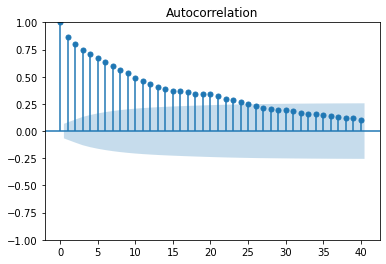

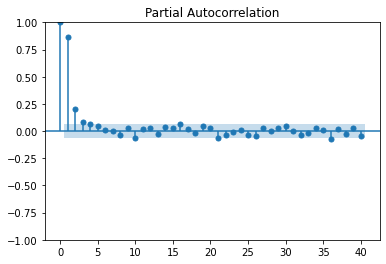

In [22]:
adf_test(WFLY2)
acf_pacf_plot(WFLY2)

#### Step 3 on Out of sample data

In [23]:
end_date_3m = (pd.to_datetime("2015-07-31", format="%Y-%m-%d") + pd.Timedelta("90D")).strftime("%Y-%m-%d")
end_date_6m = (pd.to_datetime("2015-07-31", format="%Y-%m-%d") + pd.Timedelta("180D")).strftime("%Y-%m-%d")

In [24]:
WFLY2_out_of_sample_3m = r[0] * df.loc["2015-07-31":end_date_3m]["3 YR"] - df.loc["2015-07-31":end_date_3m]["5 YR"] + r[1] * df.loc["2015-07-31":end_date_3m]["7 YR"]
print(f"halflife of WFLY2 using 3m out of sample periods is {get_halflife(WFLY2_out_of_sample_3m)}")

halflife of WFLY2 using 3m out of sample periods is 5.0877


Half life of WFLY2 using 3m out of sample is very close to the one using in sample data, there is still some prediction ability 

In [26]:
adf_test(WFLY2_out_of_sample_3m)

Test Statistic                 -2.294016
p-value                         0.173905
#Lags Used                      0.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [27]:
WFLY2_out_of_sample_6m = r[0] * df.loc["2015-07-31":end_date_6m]["3 YR"] - df.loc["2015-07-31":end_date_6m]["5 YR"] + r[1] * df.loc["2015-07-31":end_date_6m]["7 YR"]
print(f"halflife of WFLY2 using 6m out of sample periods is {get_halflife(WFLY2_out_of_sample_6m)}")

halflife of WFLY2 using 6m out of sample periods is 11.8316


In [28]:
adf_test(WFLY2_out_of_sample_6m)

Test Statistic                  -1.841101
p-value                          0.360255
#Lags Used                       1.000000
Number of Observations Used    120.000000
Critical Value (1%)             -3.486056
Critical Value (5%)             -2.885943
Critical Value (10%)            -2.579785
dtype: float64


From the above test statistics we can see that larger the out of sample period, more unstable the WFLY will be